In [1]:
import data, utils, processing, plot, metric
import matplotlib.pyplot as plt
import numpy as np

root = "E:/Deep_Learning/Respiration/"

data_root = f"{root}DATA/"
plot_root = f"{root}PLOT/"

In [2]:
# with open(f"{root}sample.txt", "w") as f:
#     patient_path, num_fx = data.patient_path(data_root, "ARC", "Breathhold")
#     patient_ID = patient_path.split("/")[5].split("_")[0]
#     RPD_per_fld, STB_per_fld = [], [] # Metric over entire session (each metric is calculated for each field)
#     RPD_per_fx, STB_per_fx = [], [] # Metric over entire session (each metric is calculated for each fraction)
#     for fx in range(1, num_fx+1):
#         print(f"\t\t\t\t=====Fraction{fx}=====\n\n")
#         fraction_path, num_fld = data.fraction_path(patient_path, fx)
#         rpds_per_fld, stbs_per_fld = [], [] # Reproducibility & Stability over each field -> [fld_rpd1, fld_rpd2, ...]
#         fx_lvls, fx_errors = [], [] # Avg_lvl & Vert_error for each fraction (over ALL fields) -> [avg_lvl1, avg_lvl2, ...]
#         for field in range(1, num_fld+1):
#             print(f"\t\t\t\t =====Field{field}=====\n")
#             (data_Times, data_Amps), (beam_Times, beam_Amps) = data.read_field_data(fraction_path, field)
#             dilated_beams = processing.dilate_beams(data_Times, beam_Times, beam_Amps)
#             cutted_amps = np.array(data_Amps) * np.array(dilated_beams)
#             enabled_intervals, num_intvs = processing.beam_enabling_intervals(data_Times, cutted_amps)
#             field_lvls, field_errors = [], []
#             for intv in range(num_intvs):
#                 avg_lvl = metric.avg_lvl_per_interval(enabled_intervals[intv]) * 10 # cm -> mm
#                 error = metric.error_per_interval(enabled_intervals[intv]) * 10     # cm -> mm
#                 field_lvls.append(avg_lvl)
#                 field_errors.append(error)
#                 fx_lvls.append(avg_lvl)
#                 fx_errors.append(error)
#             fld_reprod = metric.reprod_per_field(field_lvls)
#             fld_stab = metric.stab_per_field(field_errors)
#             rpds_per_fld.append(fld_reprod)
#             stbs_per_fld.append(fld_stab)
#             print(f"Reproducibility (mm): {fld_reprod}\tStability (mm): {fld_stab}\n\n")
#         fx_mean_reprod = metric.mean_reprod_per_fraction(rpds_per_fld)
#         fx_mean_stab = metric.mean_stab_per_fraction(stbs_per_fld)
#         fx_rpd = metric.reprod_per_field(fx_lvls)
#         fx_stb = metric.stab_per_field(fx_errors)
#         RPD_per_fld.append(fx_mean_reprod)
#         STB_per_fld.append(fx_mean_stab)
#         RPD_per_fx.append(fx_rpd)
#         STB_per_fx.append(fx_stb)
#         print(f"Mean Reproducibility (mm): {fx_mean_reprod}\tMean Stability (mm): {fx_mean_stab}\n")
#         print(f"Fraction Reproducibility (mm): {fx_rpd}\tFraction Stability (mm): {fx_stb}\n\n\n")
#     R2_RPD, R2_STB = metric.R_squared(RPD_per_fx), metric.R_squared(STB_per_fx)
#     CV_RPD, CV_STB = metric.coeff_var(RPD_per_fx), metric.coeff_var(STB_per_fx)
#     print("\t\t\t\t=====R-squared=====")
#     print(f"Reproducibility: {R2_RPD}\tStability: {R2_STB}\n")
#     print("\t\t\t\t=====CV=====")
#     print(f"Reproducibility: {CV_RPD}\tStability: {CV_STB}\n")

([<matplotlib.lines.Line2D at 0x24e7288bad0>],
 [<matplotlib.lines.Line2D at 0x24e73a83d50>])

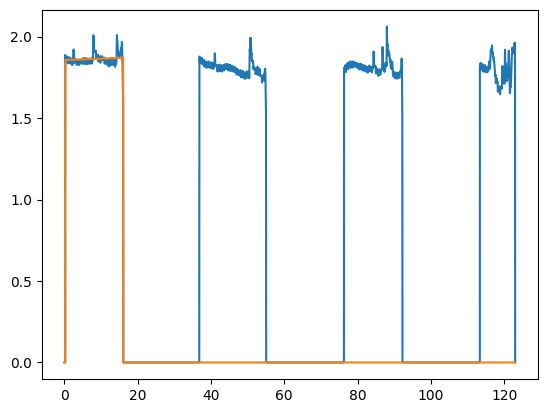

In [3]:
patient_path, num_fx = data.patient_path(data_root, "ARC", "Breathhold")
fraction_path, num_fld = data.fraction_path(patient_path, 1)
(data_Times, data_Amps), (beam_Times, beam_Amps) = data.read_field_data(fraction_path, 1)
dilated_beams = processing.dilate_beams(data_Times, beam_Times, beam_Amps)
cutted_amps = np.array(data_Amps) * np.array(dilated_beams)
enabled_intervals, num_intvs = processing.beam_enabling_intervals(data_Times, cutted_amps)

dt = 0.015
curr_interval = enabled_intervals[0]
Times = [t*dt for t in range(len(curr_interval))]
slope, intercept = np.polyfit(Times, curr_interval, deg=1)
fitted = [slope*t+intercept for t in Times]

dilated_line = processing.dilate_fitted_line(0, data_Times, beam_Times, fitted)
plt.plot(data_Times, cutted_amps), plt.plot(data_Times, dilated_line)